In [4]:
import pandas as pd
from pathlib import Path
import numpy as np
from predcontrol_sf.data_loader import load_data_bom_aus
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import datetime as dt
import mlflow
import torch


In [5]:
data_folder = Path(r"C:\Users\sgnodde\Documents\data\data_murray_boundary_bend")

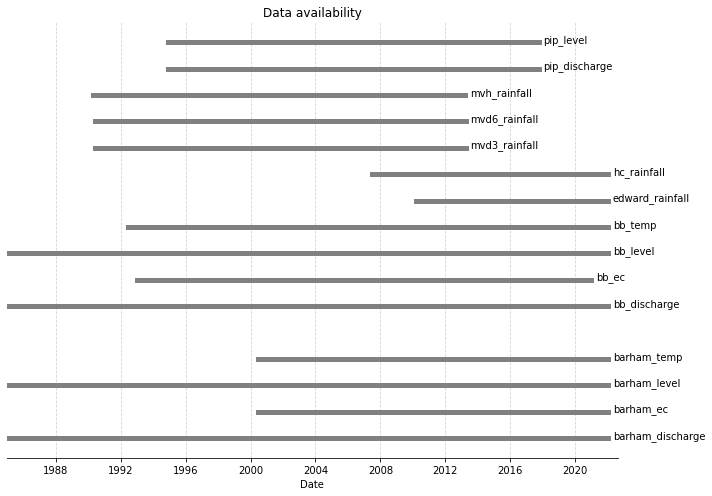

In [17]:

fig = plt.figure(figsize=(10,7))
ax = plt.subplot(111)

ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plot_start_end
pathlist = data_folder.glob('**/*.csv')
for i, path in enumerate(pathlist):
    if 'pred' in str(path):
        continue
    data = load_data_bom_aus(path)
    plt.plot([data.index[0], data.index[-1]], [i, i], linewidth = 5, color = 'grey')
    plt.text(data.index[-1]+dt.timedelta(days=100), i, path.stem)

    
plt.xlim(dt.datetime(1985,1,1),dt.datetime.now()+dt.timedelta(days=200))
plt.xlabel("Date")
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
plt.title("Data availability")
plt.tight_layout()
plt.savefig(r'C:\Users\sgnodde\Documents\data\Murray project\data_av.png', dpi = 200, bbox_inches='tight')

ax.grid(which='major', axis='x', linestyle='--', color='lightgrey')

In [ ]:
edward_rainfall = load_data_bom_aus(data_folder / 'edward_rainfall.csv')
startdt = edward_rainfall.index[0]
edward_rainfall

,Value,Quality Code,Interpolation Type
date,,,
2010-03-12 08:59:00+10:00,0.0,140,206
2010-03-12 09:00:00+10:00,0.0,140,206
2010-03-13 09:00:00+10:00,0.0,140,206
2010-03-14 09:00:00+10:00,0.0,140,206
2010-03-15 09:00:00+10:00,0.0,140,206
...,...,...,...
2022-01-13 09:00:00+10:00,0.0,140,206
2022-01-14 09:00:00+10:00,0.0,140,206
2022-01-15 09:00:00+10:00,0.0,140,206


In [77]:
3693/(11*365)

0.9198007471980074

<AxesSubplot:>

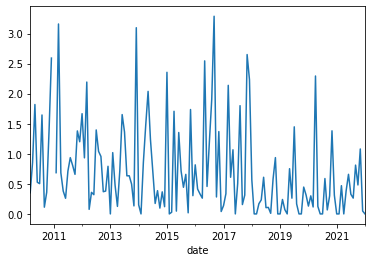

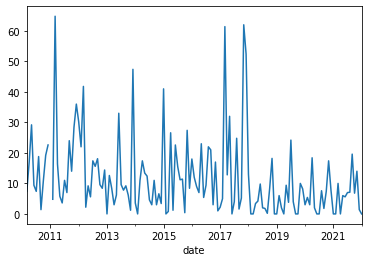

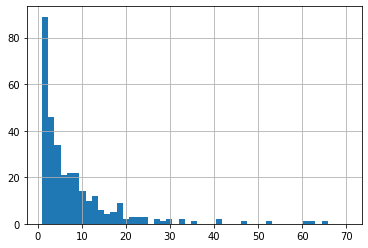

In [78]:
edward_rainfall['Value'].resample('m').mean().plot()
plt.figure()
edward_rainfall['Value'].resample('m').max().plot()
plt.figure()
edward_rainfall['Value'].hist(bins=np.linspace(1,70))

In [79]:
hc_rainfall = load_data_bom_aus(data_folder / 'hc_rainfall.csv')


In [80]:
bb_discharge = load_data_bom_aus(data_folder / 'bb_discharge.csv')

In [81]:
bb_discharge['Value'].autocorr()


0.999979606265687

In [82]:
bb_discharge['Value'].resample('m').mean().autocorr()

0.7818034379121457

<AxesSubplot:xlabel='date'>

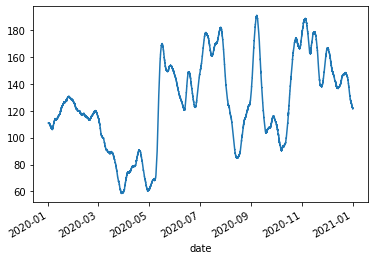

In [83]:
bb_discharge['Value']['2020'].plot()

It starts to get interesting from a prediction of 1 to 2 weeks ahead


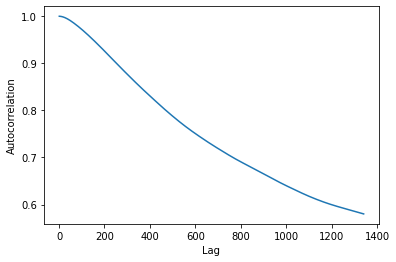

In [84]:
lags = np.arange(1,4*24*7*2,4)
autocorr = [bb_discharge['Value'].autocorr(lag=lag) for lag in lags]
plt.plot(lags, autocorr)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
print("It starts to get interesting from a prediction of 1 to 2 weeks ahead")


<AxesSubplot:>

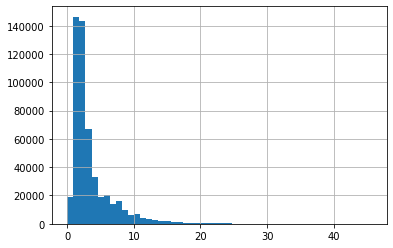

In [85]:
(bb_discharge['Value']*0.02).hist(bins=50)

Text(0, 0.5, 'Autocorrelation')

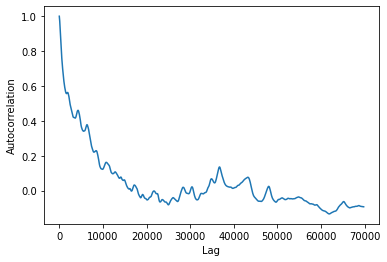

In [86]:
lags = np.arange(1,4*24*7*104,4*24)
autocorr = [bb_discharge['Value'].autocorr(lag=lag) for lag in lags]
plt.plot(lags, autocorr)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')


In [87]:
import lightgbm as lgb

In [88]:
rainfall = edward_rainfall.shift(-1)

In [89]:
level = load_data_bom_aus(data_folder / 'bb_level.csv')

In [90]:
barham_level = load_data_bom_aus(data_folder / 'barham_level.csv')

## Build dataset

In [91]:
#TODO: watertemperatuur en debiet bovenstrooms toevoegen

data = bb_discharge[['Value']].copy().rename(columns={'Value':'discharge'})
data = data.resample('d').mean()
data['rainfall'] = rainfall['Value'].resample('d').mean()

data['rainfall'] = data['rainfall'].interpolate(method="pad")
data['rainfall_rolling'] = data['rainfall'].rolling(7).mean()

data['discharge'] = data['discharge'].interpolate()


data['level'] = level['Value'].resample('d').mean()
data['level_diff'] = data['level'].diff()
data['level_diff_2'] = data['level'].diff(2)

data['barham_level'] = barham_level['Value'].resample('d').mean()
data['barham_level_1'] = data['barham_level'].shift(1)
data['barham_level_2'] = data['barham_level'].shift(2)
data['barham_level_rolling'] = data['barham_level'].rolling(6).mean()

DAYS_IN_YEAR = 365.25
norm_index = 2 * np.pi * data.index.dayofyear / DAYS_IN_YEAR
data['sin_day'] = np.sin(norm_index)
data['cos_day'] = np.cos(norm_index)
for i in [3,9,20]:
    for column in ['discharge']:
        data[f'{column}_rolling_{i}'] = data[column].rolling(i).mean()
data['target'] = data['discharge'].shift(-7)

data = data.dropna()

data_train = data.loc[:"2016"]

data_valid = data.loc["2017":"2019"]
data_test = data.loc["2020":]
X_train = data_train.drop(columns="target")
y_train = data_train['target']
X_valid = data_valid.drop(columns="target")
y_valid = data_valid["target"]



In [92]:
data.head()

,discharge,rainfall,rainfall_rolling,level,level_diff,level_diff_2,barham_level,barham_level_1,barham_level_2,barham_level_rolling,sin_day,cos_day,discharge_rolling_3,discharge_rolling_9,discharge_rolling_20,target
date,,,,,,,,,,,,,,,,
2010-03-18 00:00:00+10:00,84.806844,0.0,0.0,1.768198,0.052510,0.132521,2.496455,2.508000,2.459000,2.399873,0.969843,0.243730,81.279354,71.961917,68.919601,78.715292
2010-03-19 00:00:00+10:00,87.093542,0.0,0.0,1.807594,0.039396,0.091906,2.393556,2.496455,2.508000,2.417174,0.973892,0.227011,84.569365,74.352043,69.561803,71.396563
2010-03-20 00:00:00+10:00,90.029385,0.0,0.0,1.856792,0.049198,0.088594,2.225333,2.393556,2.496455,2.404272,0.977653,0.210225,87.309924,77.134831,70.475322,63.311833
2010-03-21 00:00:00+10:00,91.122042,0.0,0.0,1.874979,0.018187,0.067385,2.022583,2.225333,2.393556,2.350821,0.981125,0.193376,89.414990,80.052554,71.586679,56.429021
2010-03-22 00:00:00+10:00,90.332354,0.0,0.0,1.861844,-0.013135,0.005052,1.804043,2.022583,2.225333,2.241662,0.984306,0.176471,90.494594,82.707039,72.783559,52.159604


In [93]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

In [94]:
from mlflowcollab import mlflow_run_sklearn, get_directory_prompt, new_experiment, setup_mlflow, open_mlflowui_browser
mlrunsfolder = Path(r'C:\Users\sgnodde\Documents\data\mlruns')
Path(mlrunsfolder).mkdir(parents=True, exist_ok=True)
setup_mlflow('Murray_bb_1', mlrunsfolder)

In [95]:
get_directory_prompt()

C:\Users\sgnodde\Documents\data


'C:\\Users\\sgnodde\\Documents\\data'

In [96]:
open_mlflowui_browser()

In [97]:
for i in range(100):

    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'l2', 'l1'},
        'num_leaves': np.random.randint(2,20),
        'learning_rate': np.random.uniform(0.01,0.1),
        'feature_fraction': np.random.uniform(0.3,1),
        'bagging_fraction': np.random.uniform(0.3,.8),
        'bagging_freq': np.random.randint(2,10),
        'verbose': 0        
    }
    with mlflow.start_run():
        gbm = lgb.train(params,
            lgb_train,
            num_boost_round=1000,
            valid_sets=lgb_eval,
            callbacks=[lgb.early_stopping(stopping_rounds=10)])
        mlflow.log_params(params)
        y_pred = gbm.predict(X_valid, num_iteration=gbm.best_iteration)
        # eval
        r2_valid = r2_score(y_valid, y_pred)
        if r2_valid > 0.5:
            mlflow.log_metric('r2', r2_valid)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000808 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[208]	valid_0's l2: 211.937	valid_0's l1: 10.9011
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[149]	valid_0's l2: 270.346	valid_0's l1: 12.5354
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000641 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[241]	valid_0's l2: 202.277	valid_0's l1: 10.6719
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the ov

In [98]:
gbm.best_score

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('l2', 199.58488850933634),
                          ('l1', 10.630630737753108)])})

In [99]:
hc_rainfall = load_data_bom_aus(data_folder / 'hc_rainfall.csv')


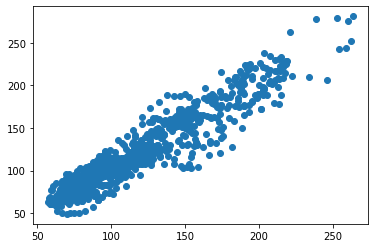

In [100]:
plt.scatter(y_valid, y_pred)

0.9350225054532421


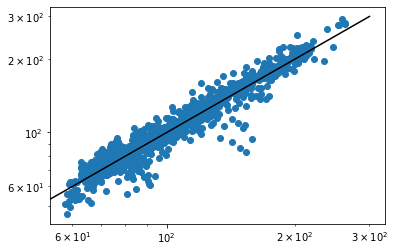

In [101]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)
print(reg.score(X_valid, y_valid))
y_pred = reg.predict(X_valid)


plt.scatter(y_valid, y_pred)
plt.plot([0,300],[0,300], 'k')
plt.yscale('log')
plt.xscale('log')

C:\Users\sgnodde\Anaconda3\envs\prediction_and_neat\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


0.9432087390593599


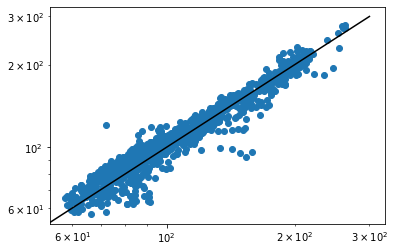

In [102]:
from sklearn.neural_network import MLPRegressor
reg = MLPRegressor(random_state=1, max_iter=1000,
    solver='adam', # adam
    alpha=0.001,
    learning_rate='adaptive',
    hidden_layer_sizes=100, activation='logistic').fit(X_train, y_train)
print(reg.score(X_valid, y_valid))
y_pred = reg.predict(X_valid)

plt.scatter(y_valid, y_pred)
plt.plot([0,300],[0,300], 'k')
plt.yscale('log')
plt.xscale('log')

In [110]:
reg = MLPRegressor(random_state=1, max_iter=1000,
    solver='adam', # adam
    alpha=0.001,
    learning_rate='adaptive',
    hidden_layer_sizes=100, activation='logistic').fit(data.drop(columns='target'), data['target'])

print(reg.score(data.drop(columns='target'), data['target']))
y_pred = reg.predict(data.drop(columns='target'))


0.9844535913145173


score is niet veel hoger dan met train test split, dus maar klein beetje overfitted

In [113]:
prediction_values = pd.DataFrame(y_pred, index = data.index, columns=['discharge_pred'])
prediction_values.resample('15min').mean().ffill()

,discharge_pred
date,
2010-03-18 00:00:00+10:00,93.655135
2010-03-18 00:15:00+10:00,93.655135
2010-03-18 00:30:00+10:00,93.655135
2010-03-18 00:45:00+10:00,93.655135
2010-03-18 01:00:00+10:00,93.655135
...,...
2022-01-09 23:00:00+10:00,200.783856
2022-01-09 23:15:00+10:00,200.783856
2022-01-09 23:30:00+10:00,200.783856


In [114]:
prediction_values.resample('15min').mean().ffill().to_csv(data_folder / 'bb_7d_disch_pred.csv')

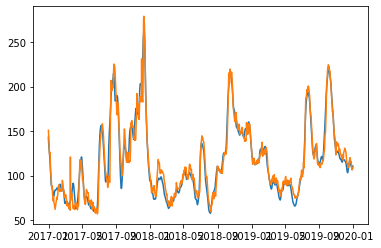

In [67]:
plt.plot(y_valid)
plt.plot(pd.Series(y_pred, index=y_valid.index))

<AxesSubplot:xlabel='date'>

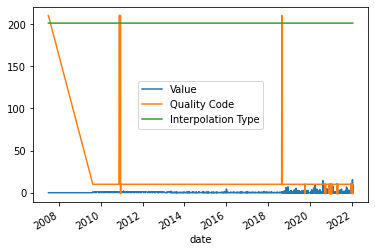

In [ ]:
hc_rainfall = load_data_bom_aus(data_folder / 'hc_rainfall.csv')


<AxesSubplot:xlabel='date'>

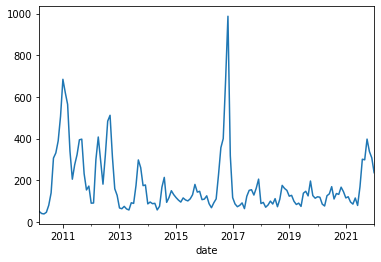

In [98]:
# TODO: QUANTILE REGRESSION 